In [2]:
# Imports
from jax import config

config.update("jax_enable_x64", True)

import jax.numpy as jnp
import jax.random as jr
import gpjax as gpx
from gpjax.typing import Array, Float

from dataclasses import dataclass

from jax import jacfwd, jacrev

import tensorflow_probability as tfp
import matplotlib.pyplot as plt

In this notebook, we reproduce the 2D simulation study, as in the [Linearly Constrained Gaussian Processes](https://papers.nips.cc/paper_files/paper/2017/hash/71ad16ad2c4d81f348082ff6c4b20768-Abstract.html) paper.

The data is a noisy measurement of a 2D divergence-free vector field.

Two different kernels are used:
- Diagonal kernel (Naïve kernel, using no information about the dataset being divergence free)
- Divergence-free kernel (Enforces the divergence-free condition globally)

# 2D div-free


3rd dimension of 0 (x), 1 (y), 2 (0 div)

## Data processing

## Latent function
The latent function is chosen to be divergence-free. It is a 2D vector field: $\mathbf f: \mathbb{R}^D\to\mathbb{R}^K$ where $D=K=2$.   
$$
\begin{aligned}
& f_1\left(x_1, x_2\right)=e^{-a x_1 x_2}\left(a x_1 \sin \left(x_1 x_2\right)-x_1 \cos \left(x_1 x_2\right)\right) \\
& f_2\left(x_1, x_2\right)=e^{-a x_1 x_2}\left(x_2 \cos \left(x_1 x_2\right)-a x_2 \sin \left(x_1 x_2\right)\right)
\end{aligned}
$$

Here, we take $a=10^{-2}$.

## Training Set
We work with a simulated training dataset $\mathcal{D} = \{(\mathbf x_i, \mathbf y_i)\}_{i=1}^{N_T}$ with inputs $\mathbf{x}$
sampled uniformly on $[0, 4]\times [0,4]$ and corresponding independent noisy outputs $\mathbf y = \mathbf f(\mathbf x)+\boldsymbol \varepsilon$.

and $\boldsymbol \varepsilon \sim \mathcal N(\mathbf 0,\sigma^2 \mathbf I)$

Here we take $\sigma =10^{-4}, N_T=50$

## Test set
The test dataset is a uniform $20\times 20$ grid on $[0,4]\times [0,4]$ and noiseless outputs. The number of prediction points is $N_P=400$.

## Processing data

### Processing data
Initially the each datum is of the form $(\mathbf x,\mathbf y)\in\mathbb{R}^D\times \mathbb{R}^K$.

This is modified to three measurements: $\{((\mathbf x, i), y_i)\}_{i=1}^D$. This ensures that the output is one dimensional, and so the kernel function is scalar valued. Explicitly, denoting the matrix-valued kernel function as $\mathbf K$ and the scalar-valued kernel function as $\tilde K$:

$$K_{ij}(\mathbf x,\mathbf x') = \tilde K((\mathbf x,i),(\mathbf x',j))$$


In [3]:
def div_free_2d_example(x, y, a=0.01):
    exp_term = jnp.exp(-a * x * y)
    trig_term_x = a * x * jnp.sin(x * y) - x * jnp.cos(x * y)
    trig_term_y = -a * y * jnp.sin(x * y) + y * jnp.cos(x * y)
    return exp_term * trig_term_x, exp_term * trig_term_y

## In-depth problem specification

In [4]:
n_divisions = 20

In [5]:
def label_position_2d(data):
    # introduce alternating z label
    n_points = len(data[0])
    label = jnp.tile(jnp.array([0.0, 1.0]), n_points)
    return jnp.vstack((jnp.repeat(data, repeats=2, axis=1), label)).T

def stack_vector(data):
    return data.T.flatten().reshape(-1, 1)

def dataset_3d(pos, obs):
    return gpx.Dataset(label_position_2d(pos), stack_vector(obs))

In [6]:
positions = jnp.mgrid[0:4:n_divisions*1j, 0:4:n_divisions*1j].reshape(2, -1)

observations = jnp.stack(
    div_free_2d_example(positions[0], positions[1]), axis=0
).reshape(2, -1)

dataset = dataset_3d(positions, observations)


In [7]:
simulation_key = jr.PRNGKey(0)

# Proposition for training data, unrestricted by a grid
train_positions = jr.uniform(key=simulation_key, minval=0.0, maxval=4.0, shape=(50, 2)).reshape(2,-1)
train_observations = jnp.stack(
    div_free_2d_example(train_positions[0], train_positions[1]), axis=0
).reshape(2, -1)
training_data = dataset_3d(train_positions, train_observations)

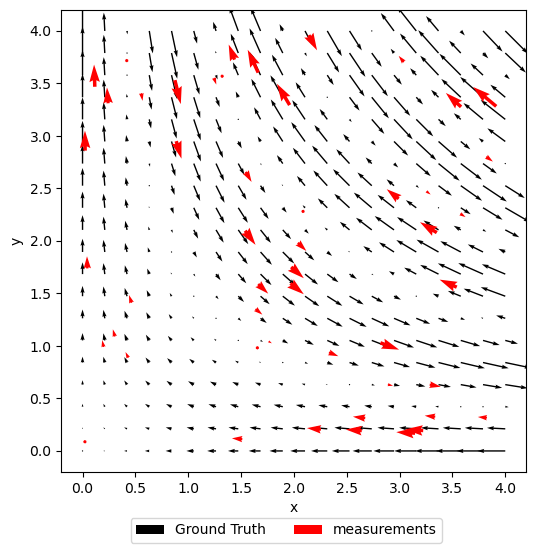

In [8]:
# Ground truth + measurements plot

fig, axs = plt.subplots(figsize=(6, 6))
# plot ground truth
axs.quiver(dataset.X[::2][:, 0], dataset.X[::2][:, 1], dataset.y[::2], dataset.y[1::2], scale=15, scale_units='y', label='Ground Truth')
# plot measurements
axs.quiver(training_data.X[::2][:, 0], training_data.X[::2][:, 1], training_data.y[::2], training_data.y[1::2], scale=15, scale_units='y', label='measurements', color='r')

axs.set_xlabel('x')
axs.set_ylabel('y')

fig.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.02))

plt.show()

### Diagonal kernel

One choice of prior distribution is a Gaussian Process with a diagonal kernel. This is where:
$$\mathbf f \sim \mathcal{GP}(\mathbf 0,k\mathbf I)$$
such that the outputs of the predicted function are independent. This is equivalent to totally separating the dataset into two different datasets: $\mathcal D_1:=\{(\mathbf x_i, y^{(1)}_i)\}_{i=0}^{400}$ and $\mathcal D_2:=\{(\mathbf x_i, y^{(2)}_i)\}_{i=0}^{400}$ and performing a Gaussian Process Regression on each dataset separately.

This does not use any prior information about the divergence-free nature of the underlying latent function, so is expected to perform worse than other methods.

In [9]:
@dataclass
class VectorKernel_2d(gpx.kernels.AbstractKernel):

    # CR TODO: should this allow specification of lengthscale and variance?
    kernel: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])

    def __call__(
        self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:
        # standard RBF-SE kernel if x and x' are on the same output, otherwise returns 0

        w = jnp.array(X[2], dtype=int)
        wp = jnp.array(Xp[2], dtype=int)

        # drop output label to reduce resource usage
        X = X[:2]
        Xp = Xp[:2]

        K = (w == wp) * self.kernel(X, Xp)

        return K


## GPJax implementation

In [10]:
def initialise_gp(kernel, mean, dataset):
    prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)
    likelihood = gpx.likelihoods.Gaussian(
        num_datapoints=dataset.n, obs_stddev=jnp.array([1.0e-3], dtype=jnp.float64)
    )
    posterior = prior * likelihood
    return posterior

In [11]:
mean = gpx.mean_functions.Zero()
kernel = VectorKernel_2d()
diagonal_posterior = initialise_gp(kernel, mean, training_data)

In [12]:
def optimise_mll(posterior, dataset, NIters=1000):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    # Optimise to minimise the MLL
    opt_posterior, _ = gpx.fit_scipy(
        model=posterior,
        objective=objective,
        train_data=dataset,
        max_iters=NIters,
    )
    return opt_posterior

In [13]:
opt_diagonal_posterior = optimise_mll(diagonal_posterior, training_data)

Optimization terminated successfully.
         Current function value: 115.603465
         Iterations: 19
         Function evaluations: 30
         Gradient evaluations: 30


## Comparison

The models are evaluated by calculating the RMSE between the predicted and true outputs. In particular,

$$RMSE = \sqrt{\frac{1}{N_P D}\sum_{i=1}^{N_P} \|\mathbf y_p-\mathbf y_t\|_2^2}$$

where $\mathbf y_p$ are the predicted values and $\mathbf y_t$ are the true values.

Field + residuals plot

In [14]:
def rmse(predictions, truth):
    # in the paper they compute RMS per vectror component
    return jnp.sqrt(jnp.sum((predictions - truth) ** 2) / truth.shape[0])

In [15]:
def latent_distribution(opt_posterior, prediction_locations, dataset_train):
    latent = opt_posterior.predict(prediction_locations, train_data=dataset_train)
    latent_mean = latent.mean()
    latent_std = latent.stddev()
    return latent_mean, latent_std

In [16]:
diagonal_mean, diagonal_std = latent_distribution(
    opt_diagonal_posterior, dataset.X, training_data
)

In [17]:
dataset_latent_diagonal = dataset_3d(positions, diagonal_mean)

In [18]:
rmse(dataset_latent_diagonal.y, dataset.y)

Array(0.88815158, dtype=float64)

In [19]:
# Ground truth + diagonal estimate + residuals plot
def field_comparison_plots(ground_truth, measurements, gp_estimate):
    fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

    axs[0].set_title('Ground Truth')

    axs[0].quiver(ground_truth.X[::2][:, 0], ground_truth.X[::2][:, 1], ground_truth.y[::2], ground_truth.y[1::2], scale=15, scale_units='y', label='Field value')
    axs[0].quiver(measurements.X[::2][:, 0], measurements.X[::2][:, 1], measurements.y[::2], measurements.y[1::2], scale=15, scale_units='y', label='measurements', color='r')

    axs[1].set_title('Diagonal Estimate')

    axs[1].quiver(dataset_latent_diagonal.X[::2][:, 0], dataset_latent_diagonal.X[::2][:, 1], dataset_latent_diagonal.y[::2], dataset_latent_diagonal.y[1::2], scale=15, scale_units='y')
    axs[1].quiver(measurements.X[::2][:, 0], measurements.X[::2][:, 1], measurements.y[::2], measurements.y[1::2], scale=15, scale_units='y', color='r')

    axs[2].set_title('Residuals')

    axs[2].quiver(ground_truth.X[::2][:, 0], ground_truth.X[::2][:, 1], ground_truth.y[::2] - gp_estimate.y[::2], ground_truth.y[1::2] - gp_estimate.y[1::2], scale=15, scale_units='y')
    axs[2].quiver(measurements.X[::2][:, 0], measurements.X[::2][:, 1], measurements.y[::2], measurements.y[1::2], scale=15, scale_units='y', color='r')

    for ax_ in axs.reshape(-1):
        ax_.set_xlabel('x')
        ax_.set_ylabel('y')

    fig.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.08))

    plt.show()

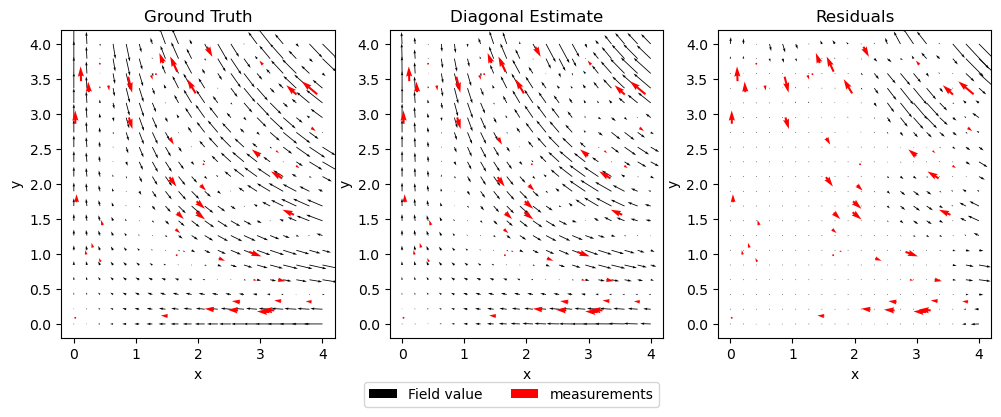

In [20]:
field_comparison_plots(dataset, training_data, dataset_latent_diagonal)

## Divergence free kernel

### Derivation of divergence free kernel
The latent function $\mathbf f$ was chosen such that it is divergence-free, in other words:
$$\boldsymbol \nabla\cdot \mathbf f := \dfrac{\partial f_1}{\partial x_1} + \dfrac{\partial f_2}{\partial x_2}=0$$

Note that*, given any differentiable function $g$, the function:
$$\mathbf f(\mathbf x):= \mathscr G_\mathbf x g := \begin{pmatrix}-\dfrac{\partial}{\partial x_2}\\ \dfrac{\partial}{\partial x_1}\end{pmatrix} g$$
automatically satisfies the required constraint.

As is the case with multivariate Gaussians, linear transformations of GPs are GPs (and they transform in much the same way).
In particular:
$$g \sim \mathcal{GP}(0, k_g) \implies \mathscr G_\mathbf x g \sim \mathcal{GP}(\mathbf 0, \mathscr G_\mathbf x k_g \mathscr G_{\mathbf x'}^\top)$$

In our case, we choose $k_g$ to be the squared exponential kernel. Therefore, any $\mathbf f$ picked from the distribution $\mathbf f \sim \mathcal {GP}(\mathbf 0, \mathscr G_\mathbf x  k_g(\mathbf x, \mathbf x') \mathscr G_{\mathbf x'}^\top)$, where

$$\mathscr G_\mathbf x  k_g(\mathbf x, \mathbf x') \mathscr G_{\mathbf x'}^\top= \begin{pmatrix}\dfrac{\partial^2}{\partial x_2 x_2'} & -\dfrac{\partial^2}{\partial x_2 x_1'}\\-\dfrac{\partial^2}{\partial x_1 x_2'} & \dfrac{\partial^2}{\partial x_1 x_1'}\end{pmatrix}k_g(\mathbf x, \mathbf x')$$
will satisfy the required constraint. This is the divergence-free kernel.

*Much of the paper is dedicated to devising a systematic way to construct $\mathscr{G}_x$ for arbitrary linear constraints.

In [21]:
def small_hessian(
    kernel, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
) -> Float[Array, "1"]:
    # compute all relevant second derivatives at once
    # eg small_hessian(k)[0][1] is d2k/dx1dy2
    return jnp.array(
        jacfwd(jacrev(kernel, argnums=0), argnums=1)(X, Xp), dtype=jnp.float64
    )

@dataclass
class DivFreeKernel(gpx.kernels.AbstractKernel):
    kernel: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])

    def __call__(
        self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:
        # the third dimension switches between 00, 01, 10 and 11 kernels

        z = jnp.array(X[2], dtype=int)
        zp = jnp.array(Xp[2], dtype=int)

        # achieve the correct value via 'switches' that are either 1 or 0
        k00_switch = ((z + 1) % 2) * ((zp + 1) % 2)
        k01_switch = ((z + 1) % 2) * zp
        k10_switch = z * ((zp + 1) % 2)
        k11_switch = z * zp

        # drop output label to reduce resource usage
        X = jnp.array(X[0:2])
        Xp = jnp.array(Xp[0:2])

        hess = small_hessian(self.kernel, X, Xp)

        K = (
            k00_switch * hess[1][1]
            - k01_switch * hess[1][0]
            - k10_switch * hess[0][1]
            + k11_switch * hess[0][0]
        )

        return K


In [22]:
kernel = DivFreeKernel()
div_free_posterior = initialise_gp(kernel, mean, training_data)

In [23]:
opt_div_free_posterior = optimise_mll(div_free_posterior, training_data)

Optimization terminated successfully.
         Current function value: 47.732612
         Iterations: 33
         Function evaluations: 36
         Gradient evaluations: 36


In [24]:
div_free_mean, div_free_std = latent_distribution(
    opt_div_free_posterior, dataset.X, training_data
)

In [25]:
dataset_latent_div_free = dataset_3d(positions, div_free_mean)

In [26]:
rmse(dataset_latent_div_free.y, dataset.y)

Array(0.32590478, dtype=float64)

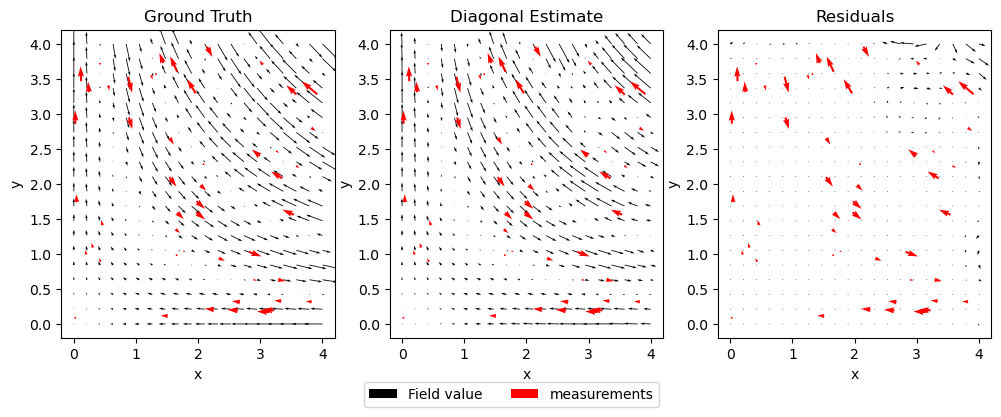

In [27]:
field_comparison_plots(dataset, training_data, dataset_latent_div_free)

## NLPD (Negative Log Predictive Density)
An alternative to RMSE for measuring how well the predicted model matches the true values. It is formally the log-likelihood of predicting the true values using the model. It is calculated using the following formula:

$$\text{NLPD} = -\sum_{i=1}^{N_PD} \log p(\mathbf f(\mathbf x_i)|\mathbf x_i)$$

Here $p(\mathbf y|\mathbf x)$ is a Gaussian distribution with mean given by the posterior mean and standard deviation given by the posterior standard deviation.

In [2]:
# ensure testing data alternates between x0 and x1 components
def nlpd(mean, std, true_observations):
    test_grid = jnp.column_stack((true_observations[0], true_observations[1])).flatten()
    normal = tfp.substrates.jax.distributions.Normal(loc=mean, scale=std)
    return -jnp.sum(normal.log_prob(test_grid))


# compute nlpd for velocity and helmholtz
nlpd_diagonal = nlpd(diagonal_mean, diagonal_std, observations)
nlpd_div_free = nlpd(div_free_mean, div_free_std, observations)

print(f"NLPD for diagonal: {nlpd_diagonal:.2E} \nNLPD for div free: {nlpd_div_free:.2E}")


NameError: name 'diagonal_mean' is not defined